In [1]:
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import pickle
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import GRU, Dense,LSTM, Dropout, BatchNormalization
# !pip install keras_tuner
from keras_tuner.tuners import RandomSearch
from tensorflow.keras.utils import plot_model
from keras.callbacks import TensorBoard
# !pip install emd
import emd
import statsmodels.api as sm

In [3]:
# Preprocesamiento de la data
with open('df_for_lstm_model.pickle', 'rb') as f:
    df = pickle.load(f)

arrays_set = []
for i in range(0,202,2):
    selected_columns = df.iloc[:, i:i+2]
    arrays = [selected_columns[col].values for col in selected_columns.columns]
    arrays_set.append(arrays)

precios_set = []
volumen_set = []
numpy_arrays_set = []

for i in arrays_set:
    precios = np.array(i[0])
    volumen = np.array(i[1])
    precios_set.append(precios)
    volumen_set.append(volumen)

for n,i in enumerate(precios_set):
    numpy_arrays_set.append([i,volumen_set[n]])

train_numpy_arrays_set = []
test_numpy_arrays_set = []
for i in numpy_arrays_set:
    train_numpy_arrays_set.append([i[0][:757], i[1][:757]])
    test_numpy_arrays_set.append([i[0][:], i[1][:]])


train_data_to_fit = np.array([train_numpy_arrays_set[0][0], train_numpy_arrays_set[0][1]]).transpose()
scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(train_data_to_fit)

indices = []
def prepare_data(x, y, window_size = 10, predict_size=1):
    X, Y = [], []
    step = 1
    for i in range(0, len(x) - window_size - predict_size + 1, step):
        X.append(np.array([x[i:i+window_size], y[i:i+window_size]]))
        Y.append(np.array([x[i+window_size:i+window_size+predict_size] , y[i+window_size:i+window_size+predict_size]]))
    return np.array(X), np.array(Y)

X_train_set = []
X_test_set = []
y_train_set = []
y_test_set = []

for n,i in enumerate(train_numpy_arrays_set):
    X, Y = prepare_data(train_numpy_arrays_set[n][0], train_numpy_arrays_set[n][1])
    X_train_set.append(X)
    y_train_set.append(Y)

for n,i in enumerate(test_numpy_arrays_set):
    X, Y = prepare_data(test_numpy_arrays_set[n][0], test_numpy_arrays_set[n][1])
    X_test_set.append(X)
    y_test_set.append(Y)

X_train_set = np.array(X_train_set)
X_test_set = np.array(X_test_set )
y_train_set = np.array(y_train_set)
y_test_set = np.array(y_test_set)

bootstraped_X_train = np.array([[arr[i] for arr in X_train_set] for i in range(len(X_train_set[0]))])
bootstraped_y_train = np.array([[arr[i] for arr in y_train_set] for i in range(len(y_train_set[0]))])

X_train = []
y_train = []
X_test = X_test_set[0]
y_test = y_test_set[0]

for i in bootstraped_X_train:
    for j in i:
        X_train.append(j)
for i in bootstraped_y_train:
    for j in i:
        y_train.append(j)

X_train = np.array(X_train)
y_train = np.array(y_train)

X_train = X_train.transpose(0, 2, 1)
X_test = X_test.transpose(0, 2, 1)
y_train = y_train.transpose(0, 2, 1)
y_test = y_test.transpose(0, 2, 1)

def scaling(data):
    original_shape = data.shape
    scaled_data = scaler.transform(data.reshape(-1,2))
    scaled_data = scaled_data.reshape(original_shape)
    return scaled_data

X_train = scaling(X_train)
X_test = scaling(X_test)
y_train = scaling(y_train)
y_test = scaling(y_test)

y_train = y_train.reshape(-1,2)
y_test = y_test.reshape(-1,2)

X_val = X_test[759:]
y_val = y_test[759:]

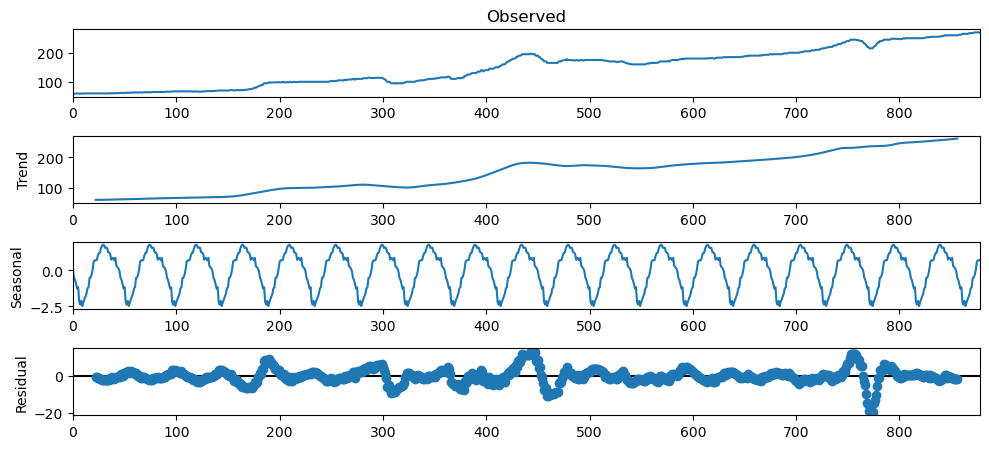

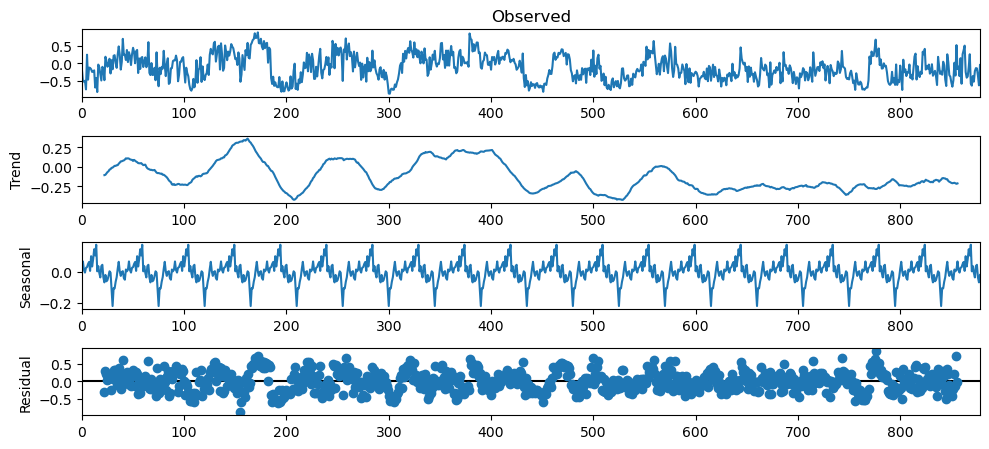

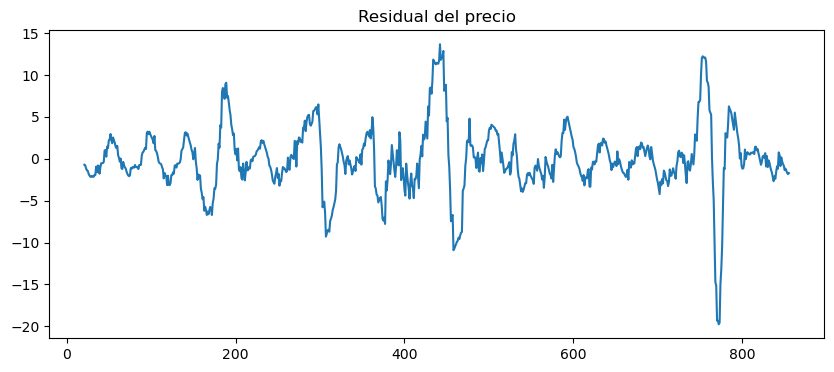

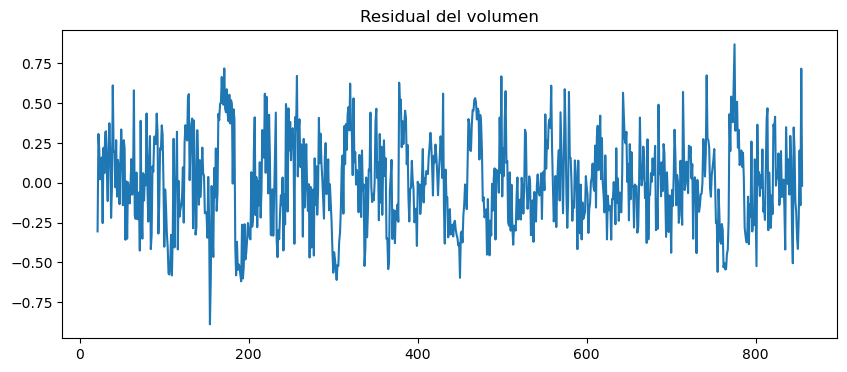

In [4]:
volume = pd.read_json('./volumeUSD.json')
with open('./price_vol_marginal.pickle','rb') as f:
    marginal_data = pickle.load(f)

usd_cup_marginal = pd.DataFrame.from_dict(marginal_data['price_mar'], orient='index', columns=['usd_cup_marginal'])
vol_marginal = pd.DataFrame.from_dict(marginal_data['vol_mar'], orient='index', columns=['vol_marginal'])
usd_cup_marginal.index = pd.to_datetime(usd_cup_marginal.index)

usd_cup = usd_cup_marginal[['usd_cup_marginal']]

diff_vol_values = pd.DataFrame({"Supply(Sales) - Demand(Purchases)":volume['Sales'] - volume['Purchases']})

time = pd.Series(usd_cup_marginal.index)



# Seasonality and trend
t = list(range(878))

decomp_precios = sm.tsa.seasonal_decompose(precios, model='additive', period=45)
fig1 = decomp_precios.plot()
fig1.set_size_inches((10, 5))
fig1.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

print('\n')

decomp_volumen = sm.tsa.seasonal_decompose(volumen, model='additive', period=45)
fig2 = decomp_volumen.plot()
fig2.set_size_inches((10, 5))
fig2.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

print('\n')

plt.figure(figsize=(10, 4))
plt.title("Residual del precio")
plt.plot(t, decomp_precios.resid[1:])
plt.show()

print('\n')

plt.figure(figsize=(10, 4))
plt.title("Residual del volumen")
plt.plot(t, decomp_volumen.resid[1:])
plt.show()

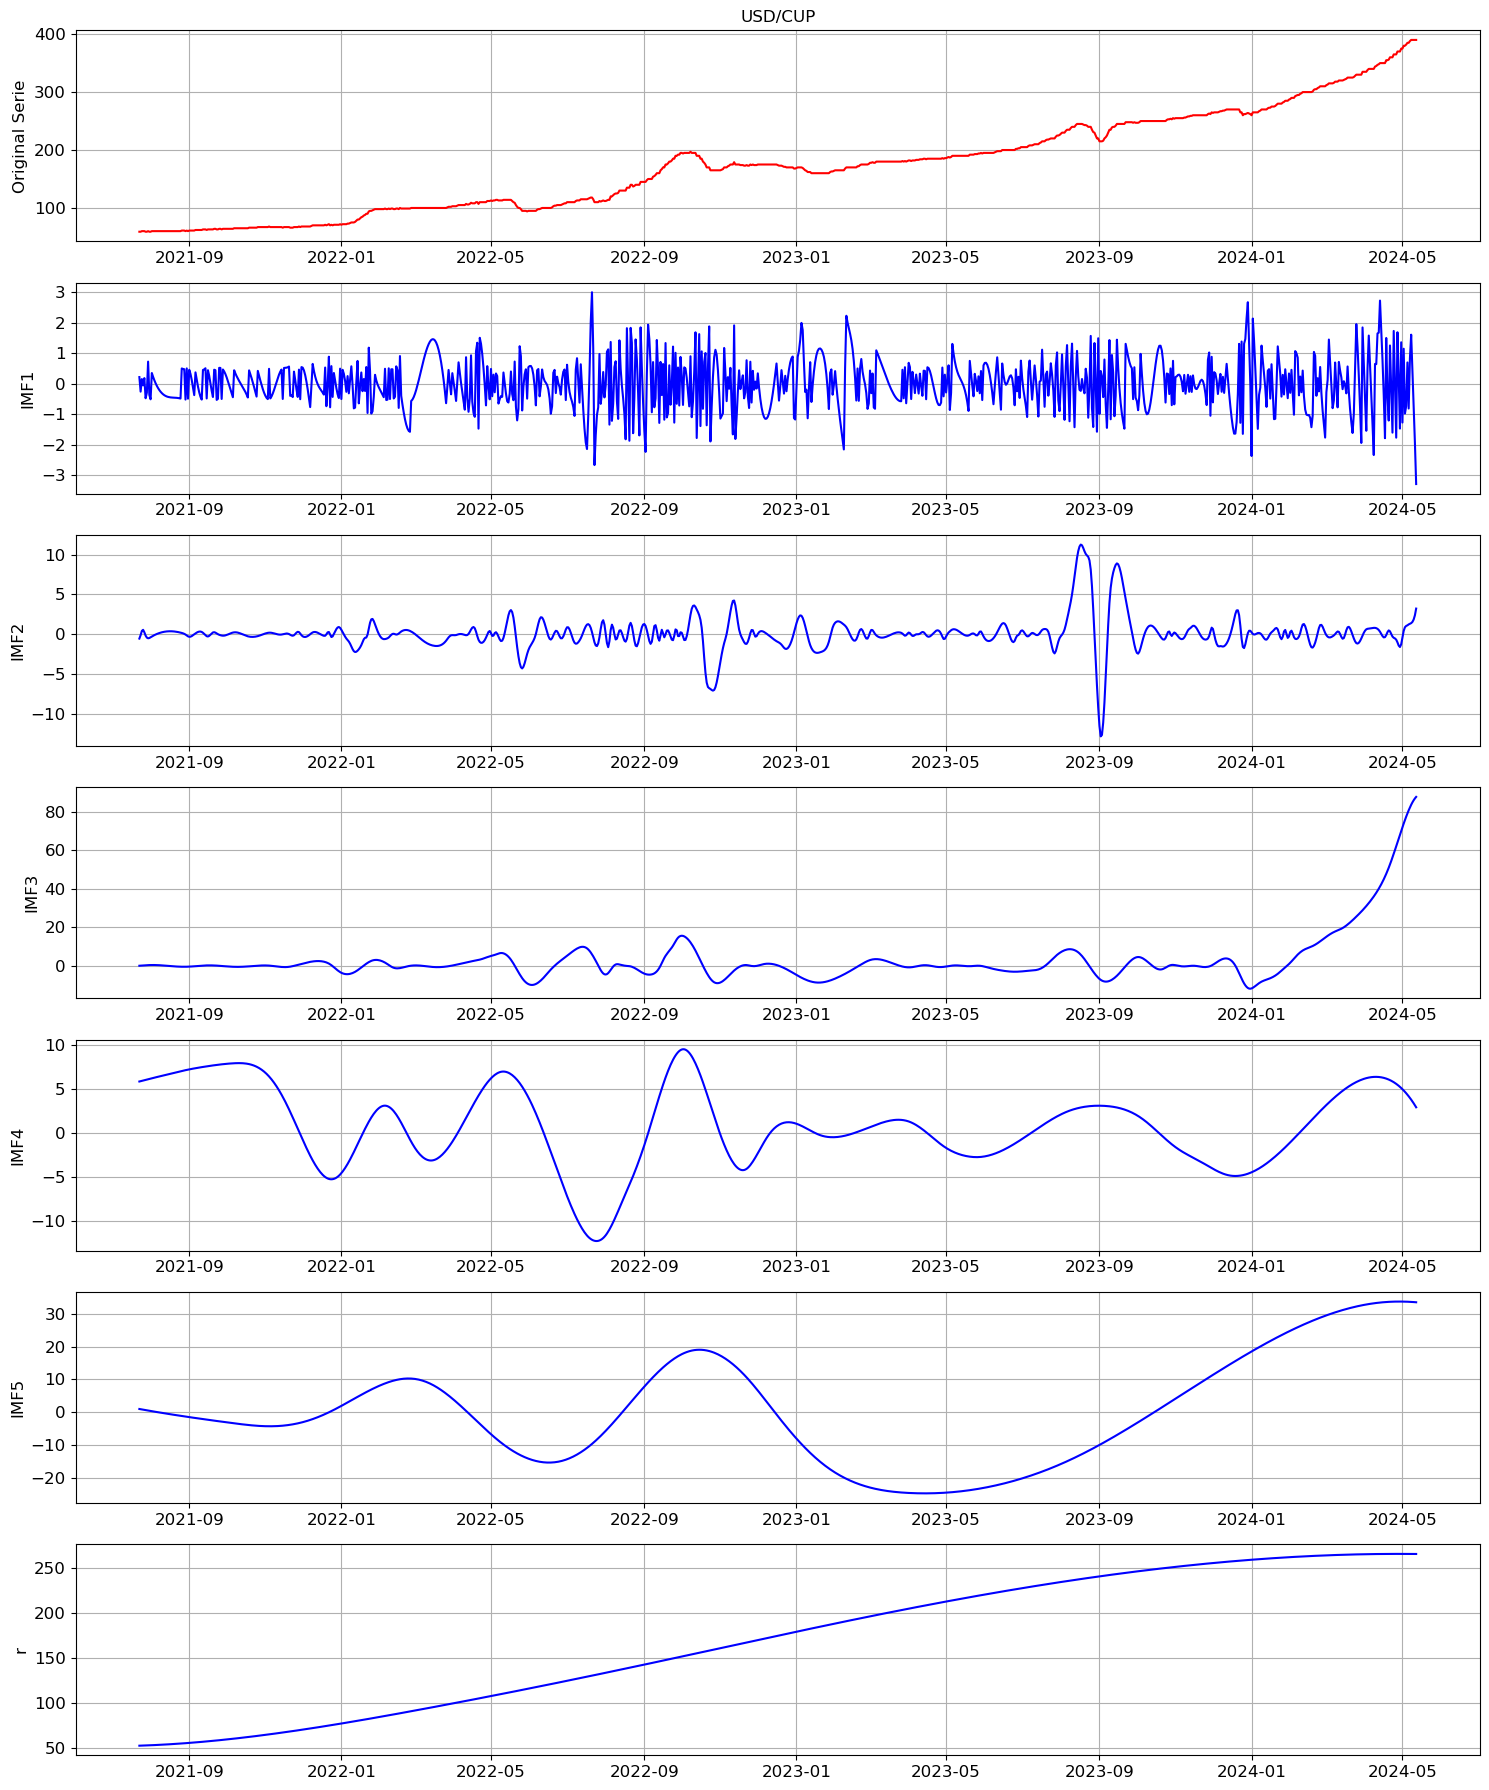

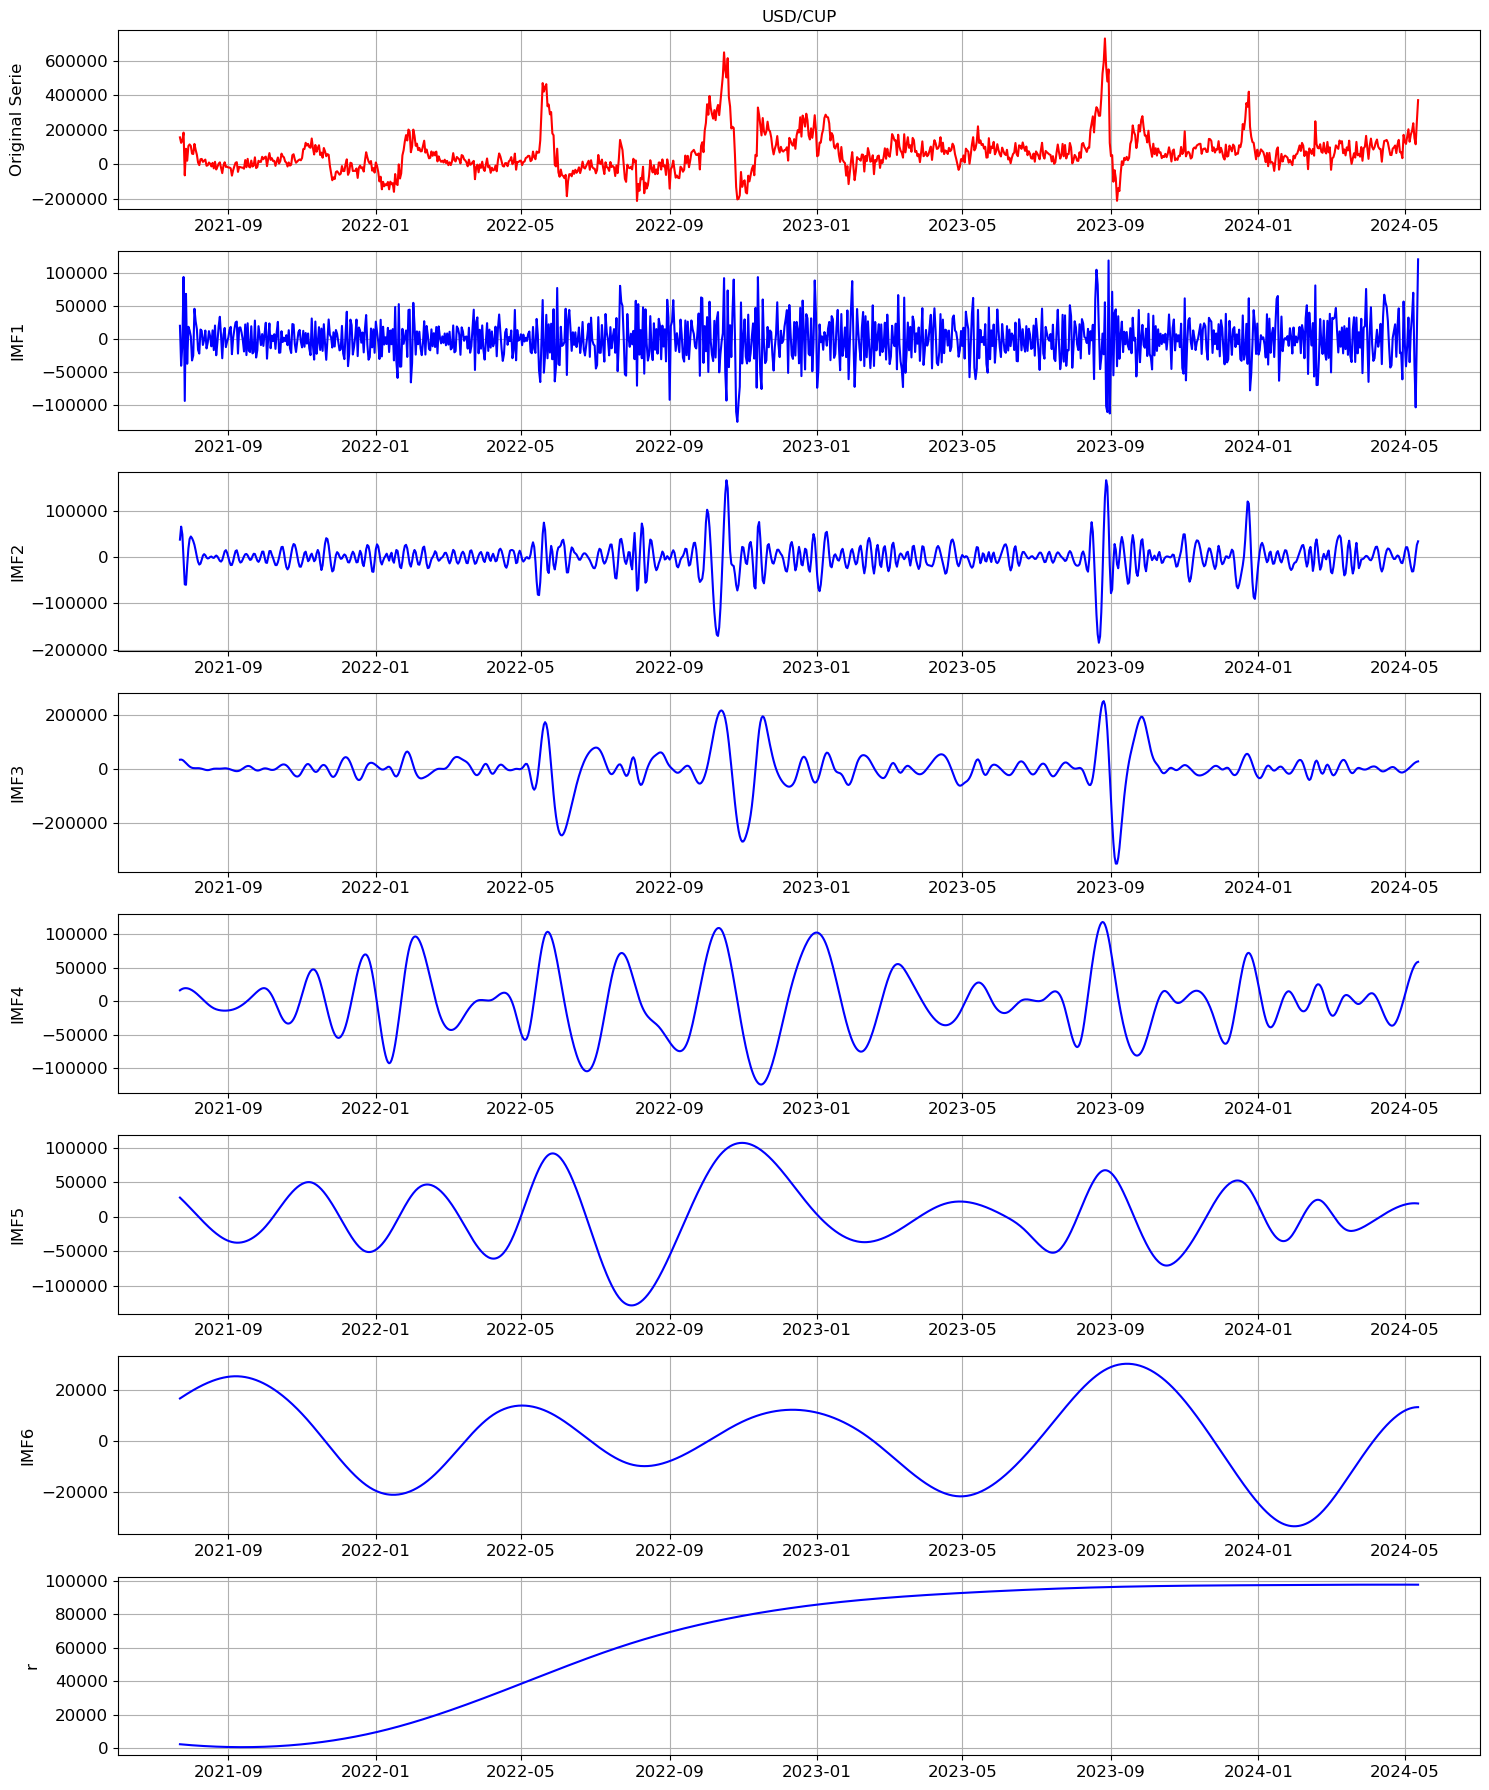

In [5]:
# Metodo para la descomposicion del modo empirico
def get_imfs(data, date):
    col=data.columns[0]
    serie = data[col].values
    imf = emd.sift.sift(serie)
    nIMFs = imf.shape[1]

    plt.figure(figsize=(15, 18))
    plt.subplot(nIMFs + 1, 1, 1)
    plt.plot(date, serie, "r")
    plt.title(f"USD/CUP")
    plt.ylabel("Original Serie", fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True)

    for n, imf_n in enumerate(imf.T):
        plt.subplot(nIMFs + 1, 1, n + 2)
        plt.plot(date, imf_n, "b")
        plt.ylabel("r" if n == nIMFs-1 else f"IMF{n+1}", fontsize=12)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.grid(True)

    plt.tight_layout()
    plt.grid(True)
    plt.show()

    return pd.DataFrame(imf)

usd_cup_imfs = get_imfs(usd_cup, time)
print('\n')
dff_volume_imfs = get_imfs(diff_vol_values, time)

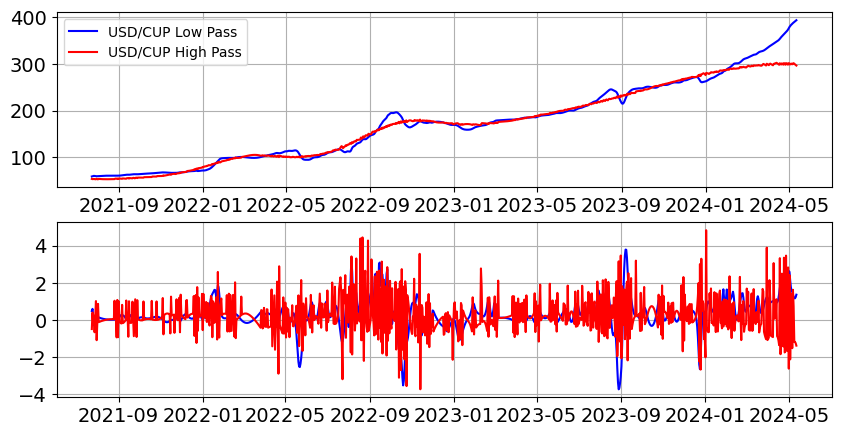

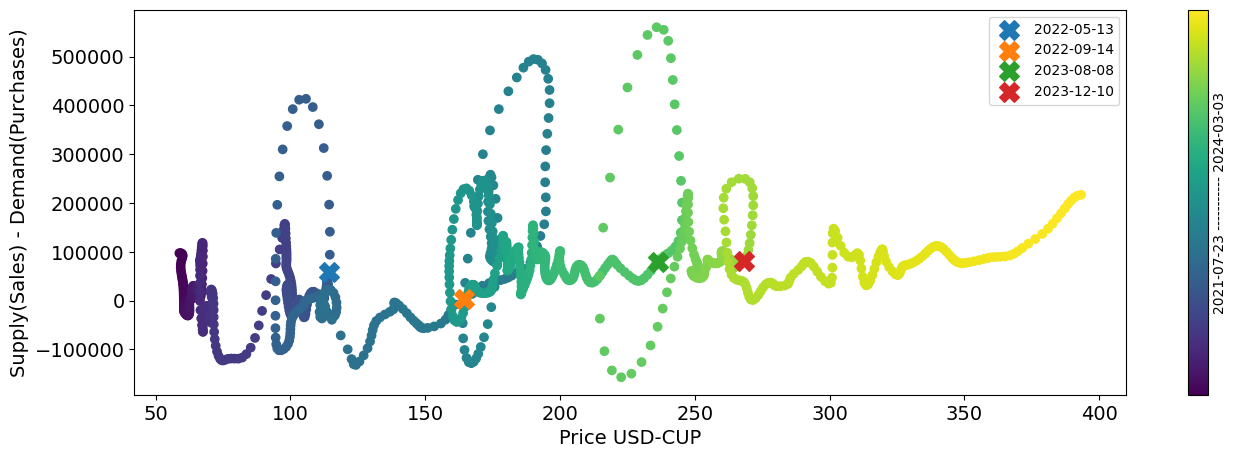

In [7]:
# Filtrando la serie con el low pass y el high pass
import matplotlib.dates as mdates

low_pass_price = usd_cup['usd_cup_marginal'].values - usd_cup_imfs[0].values
high_pass_price = usd_cup['usd_cup_marginal'].values - usd_cup_imfs[1].values - usd_cup_imfs[2].values - usd_cup_imfs[3].values

low_pass_vol = diff_vol_values['Supply(Sales) - Demand(Purchases)'].values - dff_volume_imfs[0].values - dff_volume_imfs[1].values
high_pass_vol = diff_vol_values['Supply(Sales) - Demand(Purchases)'].values - dff_volume_imfs[2].values - dff_volume_imfs[3].values
- dff_volume_imfs[4].values - dff_volume_imfs[5].values

pass_df = pd.DataFrame({'low_pass_price':low_pass_price, 'low_pass_vol':low_pass_vol, 'Date':time})

plt.figure(figsize=(10,5))
plt.subplot(2,1,1)
plt.plot(time, low_pass_price, 'b', label='USD/CUP Low Pass')
plt.plot(time, high_pass_price, 'r', label='USD/CUP High Pass')
plt.grid(True)
plt.legend()
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.subplot(2,1,2)
plt.plot(time, pd.DataFrame(low_pass_price).diff(), 'b')
plt.plot(time, pd.DataFrame(high_pass_price).diff(), 'r')
plt.grid(True)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.show()

print('\n')

dates = pass_df['Date']
colors = mdates.date2num(dates)

plt.figure(figsize=(16,5))
plt.scatter(x=pass_df['low_pass_price'], y=pass_df['low_pass_vol'], c=colors, cmap='viridis')
red_dates = ['2022-05-13', '2022-09-14', '2023-08-08', '2023-12-10']
for date in red_dates:
    x = pass_df.loc[pass_df['Date'] == date, 'low_pass_price']
    y = pass_df.loc[pass_df['Date'] == date, 'low_pass_vol']
    label = f"{date}"
    plt.scatter(x, y, marker='X', label=label, s=200)
plt.xlabel('Price USD-CUP', fontsize=14)
plt.ylabel('Supply(Sales) - Demand(Purchases)', fontsize=14)
plt.legend()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.colorbar(label='2021-07-23 ----------- 2024-03-03', ticks=[])
plt.show()

Trial 5 Complete [00h 02m 32s]
val_loss: 0.029989909380674362

Best val_loss So Far: 0.029989909380674362
Total elapsed time: 00h 12m 13s
Results summary
Results in hyperparameter_tuning/gru_tuning_1
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 4 summary
Hyperparameters:
units: 40
learning_rate: 0.001
Score: 0.029989909380674362

Trial 2 summary
Hyperparameters:
units: 32
learning_rate: 0.001
Score: 0.03024243377149105

Trial 1 summary
Hyperparameters:
units: 36
learning_rate: 0.001
Score: 0.030491916462779045

Trial 0 summary
Hyperparameters:
units: 30
learning_rate: 0.001
Score: 0.03059570863842964

Trial 3 summary
Hyperparameters:
units: 34
learning_rate: 0.001
Score: 0.030726563185453415
Epoch 1/20
10/10 [==============================] - 14s 726ms/step - loss: 0.1205 - val_loss: 0.0569
Epoch 2/20
10/10 [==============================] - 8s 764ms/step - loss: 0.0411 - val_loss: 0.0723
Epoch 3/20
10/10 [==============================] - 6s 604ms/step - l

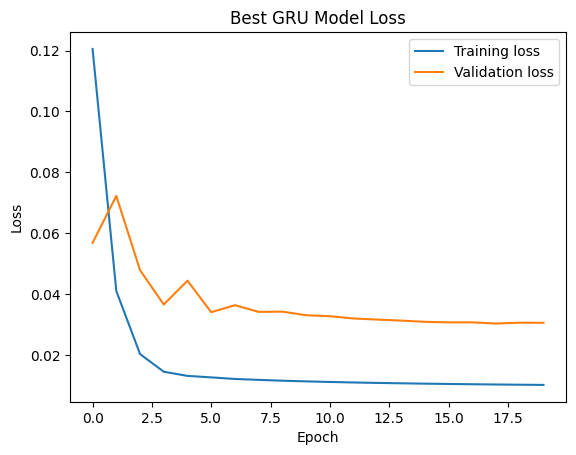

In [8]:
# Hyperparameter tuning method
input_shape = (10,2)
epochs = 20
batch_size = 8080

def create_gru_model_for_tuning(hp):
    model = Sequential()
    model.add(GRU(units=hp.Int('units', min_value=30, max_value=40, step=2), activation='tanh', input_shape=input_shape,
                  return_sequences=True))

    # model.add(Dropout(rate=hp.Float('dropout_rate', min_value=0.1, max_value=0.2, step=0.1)))

    model.add(GRU(units=hp.Int('units',min_value=30, max_value=40, step=2), activation='tanh',
                  return_sequences=True))

    # model.add(Dropout(rate=hp.Float('dropout_rate', min_value=0.1, max_value=0.2, step=0.1)))

    model.add(GRU(units=hp.Int('units',min_value=30, max_value=40, step=2), activation='tanh',
                   return_sequences=False))

    # model.add(Dropout(rate=hp.Float('dropout_rate', min_value=0.1, max_value=0.2, step=0.1)))

    model.add(Dense(2))
    model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[0.001])),
                  loss='mean_squared_error')
    return model

tuner = RandomSearch(create_gru_model_for_tuning, objective='val_loss', max_trials=5,
                     executions_per_trial=1, directory='hyperparameter_tuning',
                     project_name='gru_tuning_1')
tuner.search(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val))

best_hp = tuner.get_best_hyperparameters(1)[0]

best_gru_model = tuner.hypermodel.build(best_hp)

tuner.results_summary()

# early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

history = best_gru_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                             validation_data=(X_val, y_val), verbose=1,
                             callbacks=[])

best_gru_model.summary()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Best GRU Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training loss', 'Validation loss'], loc='upper right')
plt.show()

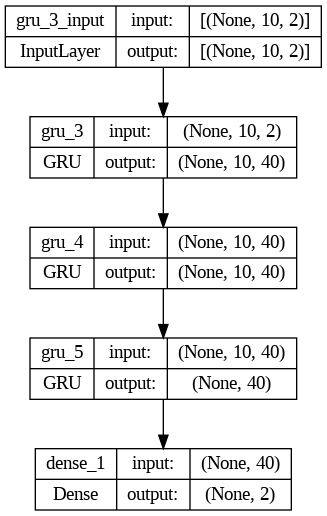

In [21]:
from tensorflow.keras.utils import plot_model

# Assuming 'model' is your Keras model
plot_model(best_gru_model, to_file='model.png', show_shapes=True, show_layer_names=True)

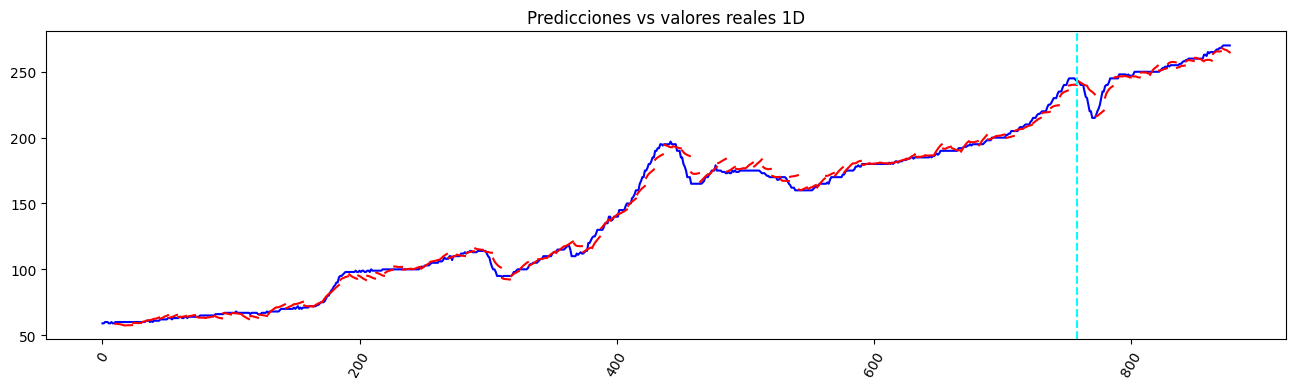

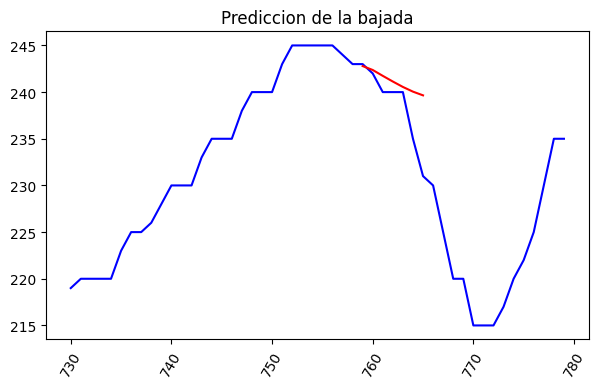

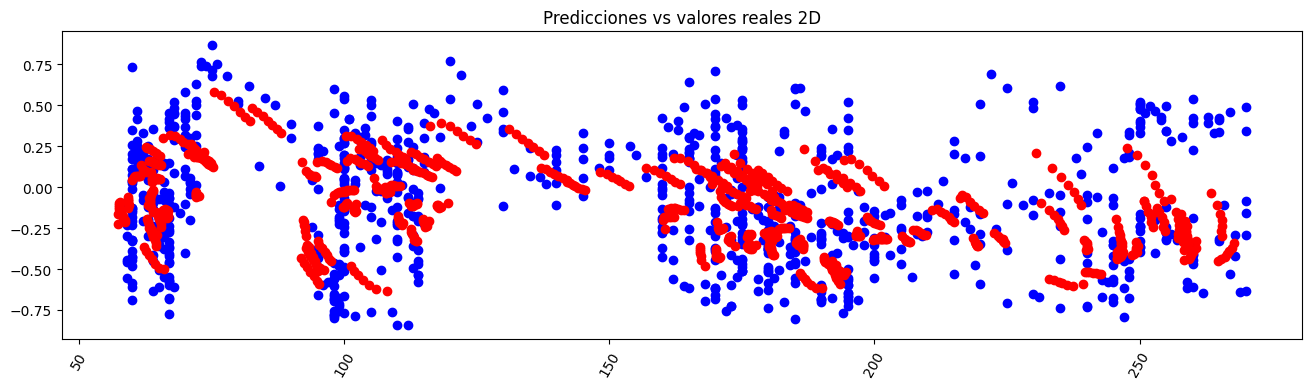

In [9]:
# Funcion para hacer las predecciones dia a dia
prediction_length=7
predictions_array = []
volumes_array = []
def get_predictions(data, index, model=best_gru_model, prediction_length=prediction_length):

    predicted_values = []
    predicted_prices = []
    predicted_volumes = []
    x_input = data[index]
    x_input = np.reshape(x_input, (1, 10, 2))
    for _ in range(prediction_length):

        prediction = model.predict(x_input, verbose=0)

        predicted_values.append(prediction[0])


        new_input = prediction[0]
        new_input = new_input.reshape((1,1,2))

        x_input = np.append(x_input[:, 1:, :], new_input, axis=1)

    predicted_values = scaler.inverse_transform(predicted_values)

    for i in predicted_values:
        predicted_prices.append(i[0])
        predicted_volumes.append(i[1])

    predictions_array.append(predicted_prices)
    volumes_array.append(predicted_volumes)


for i in range(1, len(X_test), prediction_length):
    index = i
    predict = get_predictions(X_test, index)

predictions_array = np.array(predictions_array).flatten()
volumes_array = np.array(volumes_array).flatten()

plt.figure(figsize=(16,4))
plt.title("Predicciones vs valores reales 1D")
plt.plot(df['usd_cup_marginal'][1:].values, color="blue")
for j in range(10, len(t), 7):
    plt.plot(t[j:j+7], predictions_array[(j-10):(j+7-10)], color='red')
plt.xticks(rotation=60)
plt.axvline(758, linestyle='--', color = "cyan" )
plt.show()

print('\n')

plt.figure(figsize=(7,4))
plt.title("Prediccion de la bajada")
plt.plot(range(730,780), df['usd_cup_marginal'][731:781].values, color="blue")
plt.plot(t[759:766], predictions_array[749:756], color='red')
plt.xticks(rotation=60)
plt.show()

print('\n')

plt.figure(figsize=(16,4))
plt.title("Predicciones vs valores reales 2D")
plt.scatter(df['usd_cup_marginal'][1:].values, df['diff_vol_nor'][1:].values, color="blue")
plt.scatter(predictions_array,volumes_array, color='red')
plt.xticks(rotation=60)
plt.show()

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np
import pickle
from sklearn.preprocessing import MinMaxScaler

In [11]:
#Convertir numpy arrays en torch tensors
class MyDataset(Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

train_dataset = MyDataset(X_train_tensor, y_train_tensor)
val_dataset = MyDataset(X_val_tensor, y_val_tensor)
test_dataset = MyDataset(X_test_tensor, y_test_tensor)

batch_size = 8080

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


Epoch [1/20], Train Loss: 0.1753, Val Loss: 0.3998
Epoch [2/20], Train Loss: 0.0679, Val Loss: 0.1613
Epoch [3/20], Train Loss: 0.0555, Val Loss: 0.1622
Epoch [4/20], Train Loss: 0.0411, Val Loss: 0.1699
Epoch [5/20], Train Loss: 0.0303, Val Loss: 0.1007
Epoch [6/20], Train Loss: 0.0209, Val Loss: 0.0748
Epoch [7/20], Train Loss: 0.0189, Val Loss: 0.0663
Epoch [8/20], Train Loss: 0.0169, Val Loss: 0.0532
Epoch [9/20], Train Loss: 0.0159, Val Loss: 0.0477
Epoch [10/20], Train Loss: 0.0148, Val Loss: 0.0457
Epoch [11/20], Train Loss: 0.0140, Val Loss: 0.0426
Epoch [12/20], Train Loss: 0.0132, Val Loss: 0.0403
Epoch [13/20], Train Loss: 0.0124, Val Loss: 0.0373
Epoch [14/20], Train Loss: 0.0116, Val Loss: 0.0346
Epoch [15/20], Train Loss: 0.0110, Val Loss: 0.0326
Epoch [16/20], Train Loss: 0.0105, Val Loss: 0.0314
Epoch [17/20], Train Loss: 0.0103, Val Loss: 0.0305
Epoch [18/20], Train Loss: 0.0103, Val Loss: 0.0305
Epoch [19/20], Train Loss: 0.0102, Val Loss: 0.0305
Epoch [20/20], Train 

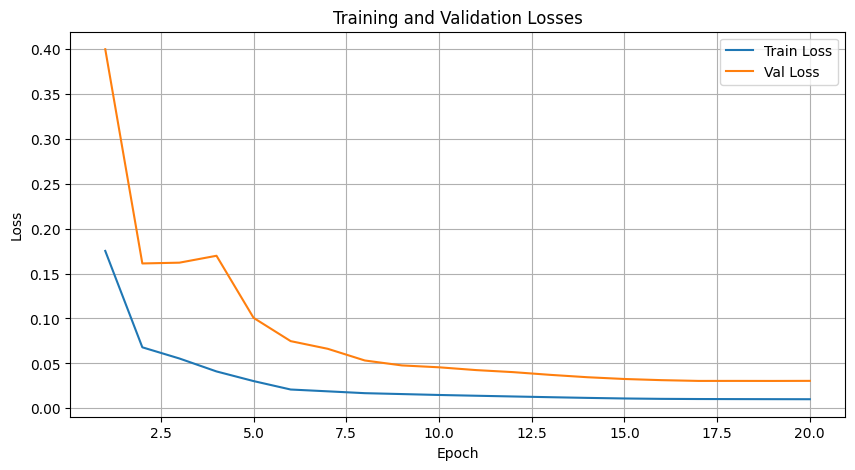



GRUModel(
  (gru): GRU(2, 40, num_layers=2, batch_first=True)
  (fc): Linear(in_features=40, out_features=2, bias=True)
)


In [17]:
#Creacion del modelo GRU
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.gru(x, h0)
        out = self.fc(out[:, -1, :])
        return out

input_size = 2
hidden_size = 40
num_layers = 2
output_size = 2

model = GRUModel(input_size, hidden_size, num_layers, output_size)

# Optimizador y funcion de coste
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Training loop
epochs = 20
train_losses = []
val_losses = []
for epoch in range(epochs):
    model.train()
    epoch_train_loss = 0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item() * inputs.size(0)
    train_losses.append(epoch_train_loss / len(train_loader.dataset))

    # Validation loop
    model.eval()
    with torch.no_grad():
        epoch_val_loss = 0
        for inputs, targets in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            epoch_val_loss += loss.item() * inputs.size(0)
        val_losses.append(epoch_val_loss / len(val_loader.dataset))

    print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}')

print("\n")

# training and validation losses vs epochs
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, epochs + 1), val_losses, label='Val Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

print("\n")
print(model)

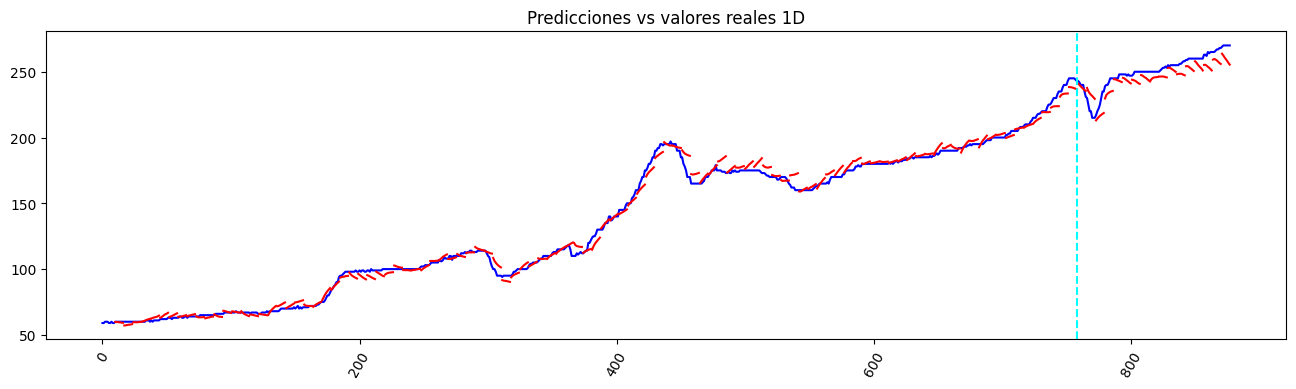

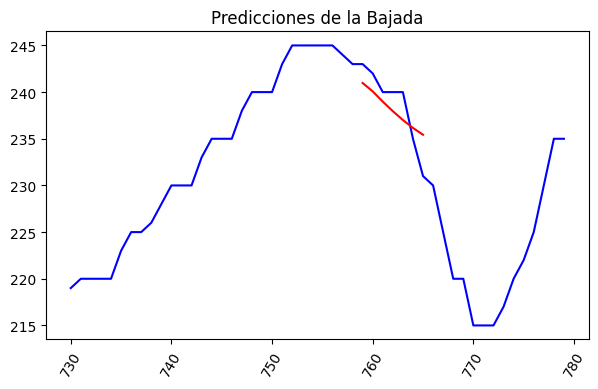

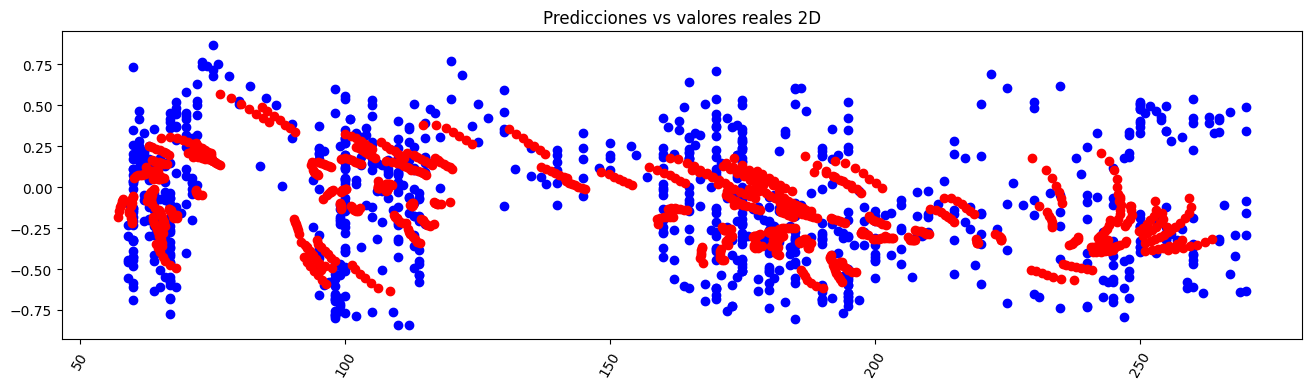

In [18]:
prediction_length = 7
predictions_array = []
volumes_array = []

def get_predictions(data, index, model, prediction_length=prediction_length):
    predicted_values = []
    predicted_prices = []
    predicted_volumes = []
    x_input = data[index]
    x_input = torch.tensor(x_input, dtype=torch.float32).unsqueeze(0)
    for _ in range(prediction_length):
        prediction = model(x_input).detach().numpy()
        predicted_values.append(prediction[0])
        new_input = prediction[0].reshape(1, 1, 2)
        x_input = torch.cat((x_input[:, 1:, :], torch.tensor(new_input, dtype=torch.float32)), dim=1)
    predicted_values = scaler.inverse_transform(predicted_values)
    for i in predicted_values:
        predicted_prices.append(i[0])
        predicted_volumes.append(i[1])
    predictions_array.append(predicted_prices)
    volumes_array.append(predicted_volumes)

for i in range(1, len(X_test), prediction_length):
    index = i
    predict = get_predictions(X_test, index, model)

predictions_array = np.array(predictions_array).flatten()
volumes_array = np.array(volumes_array).flatten()

plt.figure(figsize=(16, 4))
plt.title("Predicciones vs valores reales 1D")
plt.plot(df['usd_cup_marginal'][1:].values, color="blue")
for j in range(10, 878, 7):
    plt.plot(range(j, j + 7), predictions_array[(j - 10):(j + 7 - 10)], color='red')
plt.xticks(rotation=60)
plt.axvline(758, linestyle='--', color="cyan")
plt.show()

print('\n')

plt.figure(figsize=(7, 4))
plt.title("Predicciones de la Bajada")
plt.plot(range(730, 780), df['usd_cup_marginal'][731:781].values, color="blue")
plt.plot(range(759, 766), predictions_array[749:756], color='red')
plt.xticks(rotation=60)
plt.show()

print('\n')

plt.figure(figsize=(16, 4))
plt.title("Predicciones vs valores reales 2D")
plt.scatter(df['usd_cup_marginal'][1:].values, df['diff_vol_nor'][1:].values, color="blue")
plt.scatter(predictions_array, volumes_array, color='red')
plt.xticks(rotation=60)
plt.show()